In [1]:
import os
import polars as pl
import polars.selectors as cs
import utils
import plotly.express as px
from plotly.subplots import make_subplots
from statistics import mean

import plotly.io as pio
pio.renderers.default = "png" # needed for px figures to render on nbviewer and github

os.chdir(os.getcwd())

In [2]:
ridership_df = pl.read_csv('data/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals_20250203.csv')

ridership_df = ridership_df.rename(
    {
        'stationname': 'station_name',
        'daytype': 'day_type'
    }
)

In [3]:
ridership_df.head(10)

station_id,station_name,date,day_type,rides
i64,str,str,str,i64
41280,"""Jefferson Park""","""12/22/2017""","""W""",6104
41000,"""Cermak-Chinatown""","""12/18/2017""","""W""",3636
40280,"""Central-Lake""","""12/02/2017""","""A""",1270
40140,"""Dempster-Skokie""","""12/19/2017""","""W""",1759
40690,"""Dempster""","""12/03/2017""","""U""",499
41660,"""Lake/State""","""12/30/2017""","""A""",8615
40180,"""Oak Park-Forest Park""","""12/17/2017""","""U""",442
40250,"""Kedzie-Homan-Forest Park""","""12/02/2017""","""A""",1353
40120,"""35th/Archer""","""12/07/2017""","""W""",3353


In [4]:
# Generate int columns for year, month, and day from the date column
ridership_df = ridership_df.with_columns(
    pl.col('date').str.to_date('%m/%d/%Y')
)

ridership_df = ridership_df.with_columns(
    year=pl.col('date').dt.year(),
    month=pl.col('date').dt.month(),
    day=pl.col('date').dt.day()
)

In [5]:
# Filter to a restricted date range to limit the size of the data in memory
min_year = 2018
max_year = 2024

ridership_df = ridership_df.filter(
    pl.col('year').is_between(min_year, max_year)
)

ridership_df = ridership_df.sort(['station_id', 'year', 'month', 'day'])

In [6]:
ridership_df.head(10)

station_id,station_name,date,day_type,rides,year,month,day
i64,str,date,str,i64,i32,i8,i8
40010,"""Austin-Forest Park""",2018-01-01,"""U""",343,2018,1,1
40010,"""Austin-Forest Park""",2018-01-02,"""W""",1187,2018,1,2
40010,"""Austin-Forest Park""",2018-01-03,"""W""",1429,2018,1,3
40010,"""Austin-Forest Park""",2018-01-04,"""W""",1447,2018,1,4
40010,"""Austin-Forest Park""",2018-01-05,"""W""",1391,2018,1,5
40010,"""Austin-Forest Park""",2018-01-06,"""A""",532,2018,1,6
40010,"""Austin-Forest Park""",2018-01-07,"""U""",450,2018,1,7
40010,"""Austin-Forest Park""",2018-01-08,"""W""",1773,2018,1,8
40010,"""Austin-Forest Park""",2018-01-09,"""W""",1808,2018,1,9


In [7]:
# Check that station ID, year, month, and day uniquely identify rows in the dataset 
primary_key_columns = ["station_id", "year", "month", "day"]

assert ridership_df.unique(subset=primary_key_columns).height == ridership_df.height, "Station ID, year, month, and day are not the primary keys."

# Data Visualizations

## Yearly Rides

The plot below shoes the drastic dip in CTA rail ridership due to the COVID-19 pandemic. Annual ridership levels
fell by roughly 67% from a peak of just over 180 million passengers in 2018 to just over 60 million passengers
in 2020. While ridership has somewhat recovered, reaching 100 million passengers in 2024, it has not yet
fully recovered to its full pre-pandemic level. What is particularly noticeable is that ridership barely increased
from 2023 to 2024.

In [8]:
ridership_df_year_level = ridership_df.group_by(
    'year'
).agg(
    pl.col('rides').sum() / 1e6
).sort(
    'year'
)

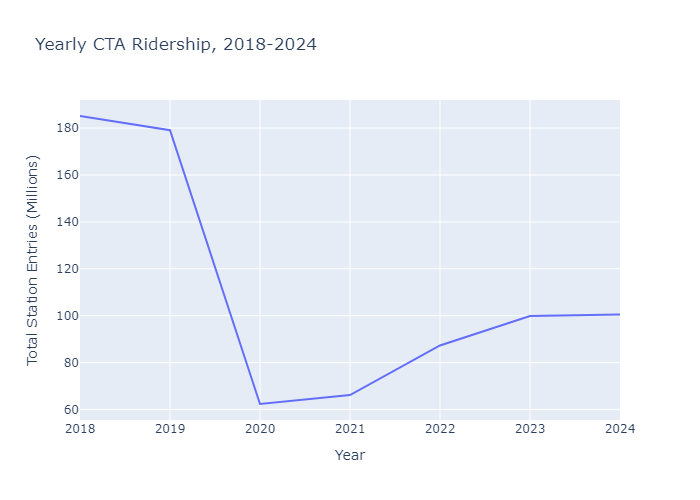

In [9]:
fig = px.line(
    ridership_df_year_level,
    x='year',
    y='rides',
    title='Yearly CTA Ridership, 2018-2024',
    labels={
        'year': 'Year',
        'rides': 'Total Station Entries (Millions)'
    }
)

fig.show()

## Ten busiest stations in 2018

The ten busiest stations in 2018 are all located in the Loop or on the North Side. Five of the top ten
(Clark/Lake; State/Lake; Fullerton; Roosevelt; Belmont-North Main) are transfer stations where passengers can move from one
CTA line to another.

In [10]:
busiest_stations_2018 = ridership_df.filter(
    pl.col('year') == 2018
).group_by(
    ['station_id', 'station_name', 'year']
).agg(
    total_ridership=pl.sum('rides')
).sort(
    'total_ridership',
    descending=True
).with_columns(
    total_ridership_millions = pl.col('total_ridership')/1e6
).head(10)

In [11]:
print(busiest_stations_2018)

shape: (10, 5)
┌────────────┬─────────────────────┬──────┬─────────────────┬──────────────────────────┐
│ station_id ┆ station_name        ┆ year ┆ total_ridership ┆ total_ridership_millions │
│ ---        ┆ ---                 ┆ ---  ┆ ---             ┆ ---                      │
│ i64        ┆ str                 ┆ i32  ┆ i64             ┆ f64                      │
╞════════════╪═════════════════════╪══════╪═════════════════╪══════════════════════════╡
│ 41660      ┆ Lake/State          ┆ 2018 ┆ 6604902         ┆ 6.604902                 │
│ 40380      ┆ Clark/Lake          ┆ 2018 ┆ 6048315         ┆ 6.048315                 │
│ 41450      ┆ Chicago/State       ┆ 2018 ┆ 4659252         ┆ 4.659252                 │
│ 40370      ┆ Washington/Dearborn ┆ 2018 ┆ 4031851         ┆ 4.031851                 │
│ 40890      ┆ O'Hare Airport      ┆ 2018 ┆ 3981492         ┆ 3.981492                 │
│ 40330      ┆ Grand/State         ┆ 2018 ┆ 3886450         ┆ 3.88645                  │
│ 4132

In [12]:
busiest_station_names_2018 = busiest_stations_2018.select('station_name').to_series()


busiest_stations_2024_from_2018 = ridership_df.filter(
    (pl.col('year') == 2024) & (pl.col('station_name').is_in(busiest_station_names_2018))
).group_by(
    ['station_id', 'station_name', 'year']
).agg(
    total_ridership=pl.sum('rides')
).sort(
    'total_ridership',
    descending=True
).with_columns(
    total_ridership_millions = pl.col('total_ridership')/1e6
)

## How busy are the 2018 ten busiest stations in 2024?

All ten stations have significantly lower ridership in 2024, and the order of the busiest stations
change. Particularly striking is that Lake/state, the busiest 2024 station depicted, has total ridership
that is even lower than Roosevelt in 2018, the least busy station.

In [13]:
busiest_stations_df_for_plot = pl.concat(
    [busiest_stations_2018, busiest_stations_2024_from_2018]
)

In [14]:
busiest_stations_df_for_plot.head(10)

station_id,station_name,year,total_ridership,total_ridership_millions
i64,str,i32,i64,f64
41660,"""Lake/State""",2018,6604902,6.604902
40380,"""Clark/Lake""",2018,6048315,6.048315
41450,"""Chicago/State""",2018,4659252,4.659252
40370,"""Washington/Dearborn""",2018,4031851,4.031851
40890,"""O'Hare Airport""",2018,3981492,3.981492
40330,"""Grand/State""",2018,3886450,3.88645
41320,"""Belmont-North Main""",2018,3813525,3.813525
40260,"""State/Lake""",2018,3779850,3.77985
41220,"""Fullerton""",2018,3751316,3.751316


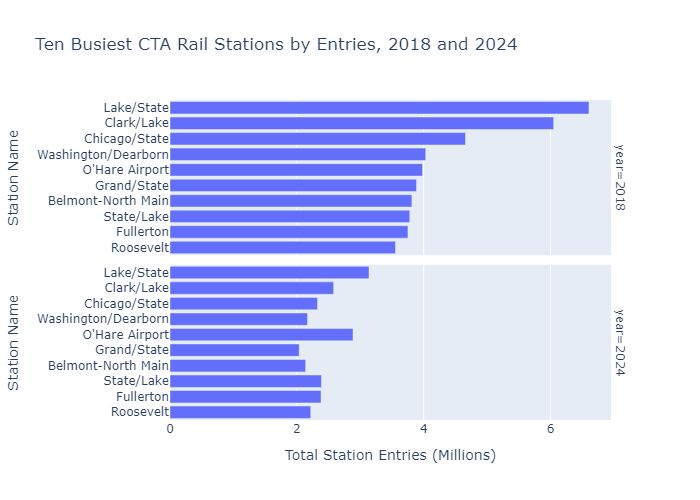

In [15]:
fig_2018_and_2024 = px.bar(
    busiest_stations_df_for_plot.sort('total_ridership_millions', descending=False),
    x='total_ridership_millions',
    y='station_name',
    orientation='h',
    facet_row='year',
    title='Ten Busiest CTA Rail Stations by Entries, 2018 and 2024',
    labels={
        'total_ridership_millions': 'Total Station Entries (Millions)',
        'station_name': 'Station Name'
    },
    category_orders={'year': [2018, 2024]}
)


fig_2018_and_2024.show()

In [16]:
ridership_loss_busiest_stations_df = busiest_stations_df_for_plot.select(
    cs.exclude('total_ridership')
).pivot(
    'year',
    values='total_ridership_millions'
).rename(
    {
        '2018': 'total_ridership_millions_2018',
        '2024': 'total_ridership_millions_2024'
    }
).with_columns(
    total_ridership_loss = pl.col('total_ridership_millions_2018') - pl.col('total_ridership_millions_2024')
)

In [17]:
ridership_loss_busiest_stations_df['total_ridership_loss'].sum()

19.854008999999998

In [18]:
ridership_loss_df = ridership_df.filter(
    (pl.col('year') == 2018) | (pl.col('year') == 2024)
).group_by(
    ['station_id', 'station_name', 'year']
).agg(
    total_ridership=pl.col('rides').sum()
).with_columns(
    total_ridership_millions = pl.col('total_ridership') / 1e6
).sort(
    'station_id',
    descending=False
).select(
    cs.exclude('total_ridership')
).pivot(
    'year',
    index=['station_id', 'station_name'],
    values='total_ridership_millions'
).rename(
    {
        '2018': 'total_ridership_millions_2018',
        '2024': 'total_ridership_millions_2024'
    }
).with_columns(
    total_ridership_loss = pl.col('total_ridership_millions_2018') - pl.col('total_ridership_millions_2024')
)

In [19]:
ridership_loss_df.head(10)

station_id,station_name,total_ridership_millions_2018,total_ridership_millions_2024,total_ridership_loss
i64,str,f64,f64,f64
40010,"""Austin-Forest Park""",0.569666,0.185092,0.384574
40020,"""Harlem-Lake""",1.165039,0.602894,0.562145
40030,"""Pulaski-Lake""",0.44685,0.26197,0.18488
40040,"""Quincy/Wells""",2.183219,1.246131,0.937088
40050,"""Davis""",1.152005,0.516225,0.63578
40060,"""Belmont-O'Hare""",1.510068,0.968448,0.54162
40070,"""Jackson/Dearborn""",2.090655,1.019296,1.071359
40080,"""Sheridan""",1.592654,0.791247,0.801407
40090,"""Damen-Brown""",0.857721,0.464871,0.39285


In [20]:
ridership_loss_df['total_ridership_loss'].sum()

84.781511

In fact, the ridership loss in these stations alone account for 19.9 million of the 84.8 million less total rides in 2024
as compared to 2018. That accounts for 23% of the total loss in ridership.

## Which stations lost the most ridership?

In [21]:
ridership_loss_top_ten = ridership_loss_df.filter(
    pl.col('total_ridership_loss').is_not_null()
).sort(
    'total_ridership_loss',
    descending=True
).head(10)

Where is ridership dropping the most from 2018 to 2024? As the below output suggests, ridership losses
seem to be concentrated in the Loop (the top 6 stations below). A plausible explanation might be the rise of
telework during the pandemic, which led to fewer office workers commuting in to the Loop during the workday. 
As Crain's Chicago finds, office occupancy in 2023 remained at less than [half](https://www.chicagobusiness.com/crains-forum-new-workplace/remote-work-pits-chicago-and-suburbs-harris-poll) of pre-pandemic levels.

In [22]:
ridership_loss_top_ten.head(10)

station_id,station_name,total_ridership_millions_2018,total_ridership_millions_2024,total_ridership_loss
i64,str,f64,f64,f64
40380,"""Clark/Lake""",6.048315,2.580192,3.468123
41660,"""Lake/State""",6.604902,3.137478,3.467424
41450,"""Chicago/State""",4.659252,2.326315,2.332937
41090,"""Monroe/State""",3.10562,1.157938,1.947682
40370,"""Washington/Dearborn""",4.031851,2.167424,1.864427
40330,"""Grand/State""",3.88645,2.036544,1.849906
40450,"""95th/Dan Ryan""",3.024989,1.341014,1.683975
41320,"""Belmont-North Main""",3.813525,2.138196,1.675329
40560,"""Jackson/State""",2.72663,1.210255,1.516375


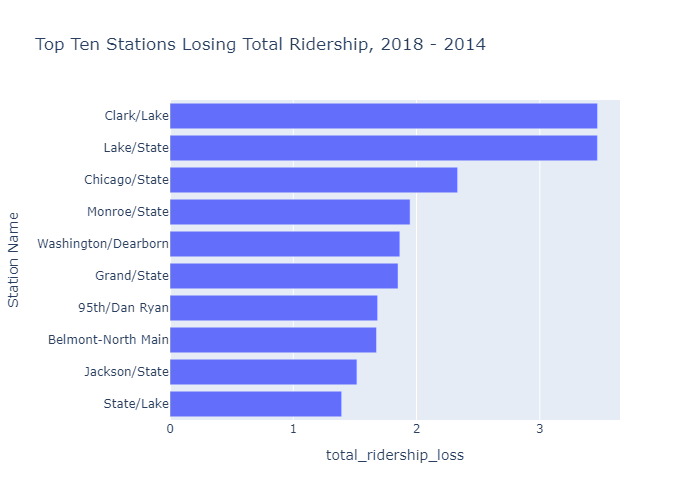

In [23]:
fig_ridership_loss_top_ten = px.bar(
    ridership_loss_top_ten.sort('total_ridership_loss', descending=False),
    x='total_ridership_loss',
    y='station_name',
    orientation='h',
    title='Top Ten Stations Losing Total Ridership, 2018 - 2014',
    labels={
        'total_ridership_millions': 'Change in Total Station Entries (Millions), 2018 - 2024',
        'station_name': 'Station Name'
    }
)

fig_ridership_loss_top_ten.show()

One way to test this theory is to compare total ridership loss from 2018 to 2024 on weekdays with 
weekends. If ridership loss seems to be greater on weekdays, that would suggest that the change in 
commuting patterns after the pandemic is a big driver of the aggregate decline in ridership. The 
CTA ridership data is at the day and station level, so we can investigate directly using the data.

In [24]:
ridership_df_weekday_station_year_level = ridership_df.with_columns(
    weekday_num=pl.col('date').dt.weekday(),
    weekday_name=pl.col('date').dt.strftime('%A')
).filter(
    (pl.col('year') == 2018) | (pl.col('year') == 2024)
).group_by(
    ['station_id', 'station_name', 'weekday_name', 'weekday_num', 'year']
).agg(
    total_ridership=pl.col('rides').sum()
).with_columns(
    total_ridership_millions = pl.col('total_ridership') / 1e6
)

# Summary df at the year and weekday level
ridership_df_year_weekday_level = ridership_df_weekday_station_year_level.group_by(
    ['year', 'weekday_name', 'weekday_num']
).agg(
    total_ridership_millions=pl.col('total_ridership_millions').sum()
).sort(
    'weekday_num',
    descending=False
)

In [25]:
# Compute 2018 ridership stats cited in the paragraph below
ridership_df_year_weekday_level.sort('total_ridership_millions', descending=True).head(10)

year,weekday_name,weekday_num,total_ridership_millions
i32,str,i8,f64
2018,"""Thursday""",4,31.555543
2018,"""Wednesday""",3,31.323307
2018,"""Tuesday""",2,31.25096
2018,"""Friday""",5,30.714092
2018,"""Monday""",1,29.067632
2018,"""Saturday""",6,17.742656
2024,"""Wednesday""",3,16.87029
2024,"""Thursday""",4,16.731001
2024,"""Tuesday""",2,16.477278


In [26]:
# Compute averages cited in the paragraph below
ridership_loss_df_year_weekday_level = ridership_df_year_weekday_level.pivot(
    'year',
    values='total_ridership_millions'
).rename(
    {
        '2018': 'total_ridership_millions_2018',
        '2024': 'total_ridership_millions_2024'
    }
).with_columns(
    total_ridership_loss = pl.col('total_ridership_millions_2018') - pl.col('total_ridership_millions_2024')
).with_columns(
    pl.when((pl.col('weekday_num').is_in([6, 7])))
    .then(pl.lit('weekend'))
    .otherwise(pl.lit('weekday'))
    .alias('day_type')
)

In [27]:
ridership_loss_df_year_weekday_level.group_by(
    'day_type'
).agg(
    mean_ridership_loss=pl.col('total_ridership_loss').mean()
)

day_type,mean_ridership_loss
str,f64
"""weekend""",5.134784
"""weekday""",14.884206


In [28]:
ridership_loss_df_year_weekday_level.group_by(
    'day_type'
).agg(
    mean_ridership=pl.col('total_ridership_millions_2018').mean()
)

day_type,mean_ridership
str,f64
"""weekend""",15.617293
"""weekday""",30.782307


The below plot provides some evidence in favor of this theory. First, CTA ridership both in 2018 and 2024
is much higher on the weekday compared to the weekend. In 2018, for example, the weekdays saw a peak on 
Thursdays with 31.6 million total rides, while Saturday, the busiest weekend, saw only 17.7 million rides.

Second, the gap between the blue line depicting 2018 ridership and the red line depicting 2024 is particularly noticeable for weekdays.
Weekdays saw an average of 14.9 million fewer rides in 2024 compared to only 5.1 million fewer rides on the weekend. This adds up to a 48% decline in average ridership on weekday rides but only a 33% decline on the weekends.

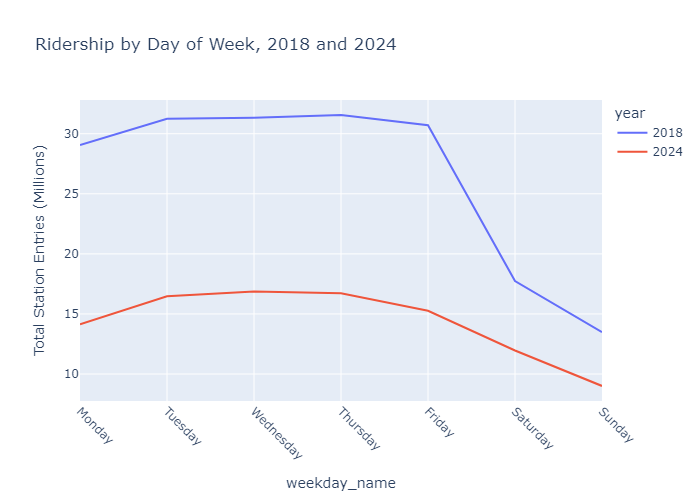

In [ ]:
fig_ridership_year_weekday = px.line(
    ridership_df_year_weekday_level,
    x='weekday_name',
    y='total_ridership_millions',
    title='Ridership by Day of Week, 2018 and 2024',
    color='year',
    labels={
        'weekday_num': 'Weekday',
        'total_ridership_millions': 'Total Station Entries (Millions)'
    }
)

fig_ridership_year_weekday.update_layout(
    xaxis={'tickangle': 45}
)

fig_ridership_year_weekday.show()